In [8]:
import pandas as pd
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

In [9]:
import xgboost as xgb
from sentence_transformers import SentenceTransformer,util

In [10]:
import sys  
sys.path.insert(1, '/home/jovyan/work/core') 
import core_utils

In [11]:
# read labelled dataset 
# This consists of 3k annotated API methods 
# These are the methods that we will use to train the model

df_labels = pd.read_csv('../inputs/yml_files.csv',index_col=None)
df_labels.drop_duplicates(subset=['keys'],keep='first',inplace=True)
true_labels = dict(zip(df_labels['keys'],df_labels['real']))

### Efficacy of representation  
### Section 4.2

### Observations

- The full table is in outputs/format_evaluation_precision.csv
- Run the cells below to read/reproduce the data for this plot

In [12]:
################ Experiment_1 using pre-trained model ################

# First we download the pre-trained model
# This line takes some time
sbert = SentenceTransformer('all-mpnet-base-v2')

# to save the model locally, run the following command
# sbert.save(path='../embeddings/sent_bert/',model_name='all-mpnet-base-v2')


In [13]:
header = ['input','learning','accuracy','precision','recall','f1']


# Name for the input dataset. Formats are ready for the embedding layer
inputs = ['yml_files.csv']
base = '../inputs/'

classifiers = []
output = []

for input in inputs:
    # read input documentation
    format = input.replace('3k_','').replace('.csv','')
    df = pd.read_csv(base + input,index_col=None)
    df.drop_duplicates(keep='first',inplace=True)
    # true label here are from block 16
    df['real'] = [true_labels[x] for x in df['keys']]
    
    # embed the method documentation
    X_original = sbert.encode(df['keys'].values)

    label_encoder = LabelEncoder()
    label_encoder = label_encoder.fit(df['real'].values)
    label_encoded_y = label_encoder.transform(df['real'].values)
    
    x_train, x_test, y_train, y_test = train_test_split(X_original,
                                    label_encoded_y, test_size=0.25, random_state=0) #

    
    # Run classifiers
    
    learning = 'logistic'
    logisticRegr = LogisticRegression()
    logisticRegr.fit(x_train, y_train)
    classifiers.append(logisticRegr)
    predicted = logisticRegr.predict(x_test)
    accuracy,precision,recall,f1 =  core_utils.get_metrics(y_test, predicted)
    output.append([format,learning,accuracy,precision,recall,f1])
    
    
    learning = 'svm'
    clf = svm.SVC(kernel='linear', C=1).fit(x_train, y_train)
    classifiers.append(clf)
    predicted = clf.predict(x_test)
    accuracy,precision,recall,f1 =  core_utils.get_metrics(y_test, predicted)
    output.append([format,learning,accuracy,precision,recall,f1])
    
    learning = 'xgboost'
    xgbc = xgb.XGBClassifier()
    xgbc.fit(x_train, y_train)
    classifiers.append(xgbc)
    predicted = xgbc.predict(x_test)
    accuracy,precision,recall,f1 =  core_utils.get_metrics(y_test, predicted)
    output.append([format,learning,accuracy,precision,recall,f1])
    
    learning = 'NN'
    nn = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(64), random_state=1,max_iter=500)
    nn.fit(x_train,y_train)
    classifiers.append(nn)
    predicted = nn.predict(x_test)
    accuracy,precision,recall,f1 =  core_utils.get_metrics(y_test, predicted)
    output.append([format,learning,accuracy,precision,recall,f1])    


df_results = pd.DataFrame(output,columns=header)

In [14]:
df_results.sort_values(by = ['learning','input'])

,input,learning,accuracy,precision,recall,f1
3,yml_files,NN,1.0,1.0,1.0,1.0
0,yml_files,logistic,1.0,1.0,1.0,1.0
1,yml_files,svm,1.0,1.0,1.0,1.0
2,yml_files,xgboost,1.0,1.0,1.0,1.0


### Table 2 observations

 To reproduce Table 2 we need to run the same classification but instead of using the default Sentence-BERT,
 the model has to be fine-tuned. 
 
 The steps for this are:
 
 1. Run the script fine_tune_script.py under work/experiments. 
     This script will store the fine-tuned model in /work/embedding/fine-tuned.
     <br>*Warning*: the process takes a long time and you might need GPUs to finish in a reasonable time. We did not try with CPUs
 2. Replace the parameter for the SentenceTransformer initialisation and run the classification again:
     <br>-`sbert = SentenceTransformer('all-mpnet-base-v2')`
     <br>+`sbert = SentenceTransformer('../embeddings/fine-tuned')`
 3. To reproduce the results of the Semantic Search-based classifier, run the cell bellow

In [20]:
# semantic search-based classifier
header = ['input','learning','accuracy','precision','recall','f1']
classifiers = []
output = []
format = 'codeql'

########## Table 2 full experiments with Semantic-Search classifier #

df = pd.read_csv('../inputs/yml_files.csv',index_col=None)
df.drop_duplicates(keep='first',inplace=True)
df['real'] = [true_labels[x] for x in df['keys']]

sbert = SentenceTransformer('all-mpnet-base-v2')
# uncomment the next line to read the fine-tuned model instead of the default
# sbert = SentenceTransformer('../embeddings_D/fine-tuned')

# embed the method documentation
X_original = sbert.encode(df['docs'].values)

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(df['real'].values)
label_encoded_y = label_encoder.transform(df['real'].values)

x_train, x_test, y_train, y_test = train_test_split(X_original,
                                    label_encoded_y, test_size=0.25, random_state=0) 

# Run classifiers

learning = 'logistic'
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
classifiers.append(logisticRegr)
predicted = logisticRegr.predict(x_test)
accuracy,precision,recall,f1 =  core_utils.get_metrics(y_test, predicted)
output.append([format,learning,accuracy,precision,recall,f1])


learning = 'svm'
clf = svm.SVC(kernel='linear', C=1).fit(x_train, y_train)
classifiers.append(clf)
predicted = clf.predict(x_test)
accuracy,precision,recall,f1 =  core_utils.get_metrics(y_test, predicted)
output.append([format,learning,accuracy,precision,recall,f1])

learning = 'xgboost'
xgbc = xgb.XGBClassifier()
xgbc.fit(x_train, y_train)
classifiers.append(xgbc)
predicted = xgbc.predict(x_test)
accuracy,precision,recall,f1 =  core_utils.get_metrics(y_test, predicted)
output.append([format,learning,accuracy,precision,recall,f1])

learning = 'NN'
nn = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(64), random_state=1,max_iter=500)
nn.fit(x_train,y_train)
classifiers.append(nn)
predicted = nn.predict(x_test)
accuracy,precision,recall,f1 =  core_utils.get_metrics(y_test, predicted)
output.append([format,learning,accuracy,precision,recall,f1])  


# Semantic Search approach 

X_original = df['docs'].values
x_train, x_test, y_train, y_test = train_test_split(X_original,
                                    df['real'].values, test_size=0.25, random_state=0) 

corpus = x_train.copy()
corpus_embeddings = sbert.encode(corpus, convert_to_tensor=True)

predicted = []
queries = x_test.copy()
learning = 'sem-search'
for query in queries:
    query_embedding = sbert.encode(query, convert_to_tensor=True)
    hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=1)
    id_corpus = hits[0][0]['corpus_id']
    label_to_compare = y_train[id_corpus]
    predicted.append(label_to_compare)
accuracy,precision,recall,f1 =  core_utils.get_metrics(y_test, predicted)
output.append([format,learning,accuracy,precision,recall,f1])  
df_results = pd.DataFrame(output,columns=header)

In [21]:
df_results

,input,learning,accuracy,precision,recall,f1
0,codeql,logistic,1.000000,1.000000,1.000,1.000000
1,codeql,svm,1.000000,1.000000,1.000,1.000000
2,codeql,xgboost,0.833333,0.833333,0.875,0.828571
3,codeql,NN,1.000000,1.000000,1.000,1.000000
4,codeql,sem-search,1.000000,1.000000,1.000,1.000000


## Baseline comparison
### Section 4.3

Here, we compare Docflow's results against SuSi and SWAN

### Semantic categories experiments

This part shows the result of the Semantic Category experiments and the experiment.

We first show the results and then provide the code to run the zero-shot classifier.

**NOTE**: Running the full experiment takes around 2hs.

In [19]:
# Table 4 results. Script to generate the table 4. 
# For the code that generates the output files, e.g. zero_format_E.csv, see the cell below 

datasets = ['zero_format_E.csv','zero_format_F.csv','zero_format_G.csv']
results = []
result_total = []
for in_format in datasets:
    out = pd.read_csv(f'../outputs/{in_format}')
    in_name = in_format.replace('.csv','').replace('zero_','')
    out['category_map_final'] = core_utils.add_cat_map(out,core_utils.inverse_map_susi)
    cols = ['category_map_final','pred_final']
    for col in cols:
        tool_name = 'docflow' if col == 'pred_final' else 'susi'
        metrics_cv = metrics.classification_report(out['real_final'], out[col],output_dict=True,zero_division=0)
        #results by averaging
        accu = metrics_cv['accuracy']
        macro_avg = metrics_cv['macro avg']
        weighted_avg = metrics_cv['weighted avg']
        result_total.append([tool_name,in_name,accu,macro_avg['precision'],macro_avg['recall'],weighted_avg['precision'],weighted_avg['recall']])
        # results per category
        for category in out[col].unique():
            res = metrics_cv[category]
            results.append([tool_name,in_name,category,res['precision'],res['recall'],res['f1-score']])
df_result_cat = pd.DataFrame(results,columns=['tool','format','category','precision','recall','f1'])
df_result_total = pd.DataFrame(result_total,columns=['tool','format','accu','m_prec','m_rec','w_prec','w_rec'])
df_result_total = df_result_total.drop(df_result_total[(df_result_total['tool'] == 'susi') & (df_result_total['format'] != 'format_E')].index)
df_result_total.sort_values(by=['tool','format'])

,tool,format,accu,m_prec,m_rec,w_prec,w_rec
1,docflow,format_E,0.863128,0.784420,0.827205,0.914059,0.863128
3,docflow,format_F,0.837989,0.824618,0.828340,0.899385,0.837989
5,docflow,format_G,0.790503,0.787120,0.761325,0.898293,0.790503
0,susi,format_E,0.597765,0.711640,0.596003,0.885422,0.597765


In [19]:
############## Table 4 Experiments (~2h running time)  ############## 

# pipeline for the zero-shot classifier 
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")
labels = pd.read_csv('../inputs/zeroshot_input_susi_true_label_final.csv')
real_cat_map = {x:y for x,y in list(zip(labels['key'],labels['real_cat']))}

base = '../inputs/'
datasets = ['zeroshot_input_susi_format_E.csv','zeroshot_input_susi_format_F.csv','zeroshot_input_susi_format_G.csv']
tmp_labels = ['log', 'nfc communication', 'audio', 'user account', 'user information','text message',
       'file information', 'network connection', 'geolocation', 'bluetooth','system settings','calendar information',
       'text message', 'contact information','media','network information','database','database information']

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [20]:
# iterate over all datasets
for dataset in datasets:
    format_name = dataset.split('_')[-1].replace('.csv','')
    df = pd.read_csv(base + dataset)
    df = df.loc[df['key'].isin(labels['key'])]
    df['real_cat'] = [real_cat_map[x] for x in df['key']]
    output = []
    # use the zero-shot model for text classification
    for text in df['docs']:
        out = classifier(text, tmp_labels)
        output.append([out['labels'][0],out['scores'][0]])
    df['label'] = [x[0] for x in output]
    df['scores'] = [x[1] for x in output]
    df['real_final'] = [core_utils.inverse_map_real[x] for x in df['real_cat']]
    df['pred_final'] = [core_utils.inverse_map_pred[x] for x in df['label']]
    # write outputs. These files are used to generate the table 4 as above
    df.to_csv(f'../output/ex_zero_format_{format_name}')

In [21]:
# label_set = set()
# for item in df['label']:
#     label_set.add(item)
# print(label_set)

### Platform libraries experiments

### Section 4.4

#### Table 5. Percentage of detected sources and sinks

Format D and xgboost classifier


In [22]:
 # Table 5 Results. These results were obtained using the fine-tuned sentence-Bert

table_5 = pd.read_csv('../outputs/libraries_prediction_detection.csv')
table_5

,Library,Package,Srcs,Sinks
0,Wearable,com.google.android.gms.wearable,0.95,0.96
1,TV,com.google.android.gms.cast.tv,0.92,1.00
2,Analytics,com.google.android.gms.analytics,1.00,0.93
3,Ads,com.google.android.gms.ads,0.92,0.85


In [23]:
# Table 5 Experiments. Here we use the pre-trained models. 
# The approach here is to train the classifiers and then use the ones with best performance
# to predict the labels for Google Play Services methods. 

inputs = ['3k_formatC.csv','3k_formatD.csv']
base = '../inputs/'
header = ['input','learning','accuracy','precision','recall','f1']
df_labels = pd.read_csv(f'{base}3k_true_labels.csv',index_col=None)
df_labels.drop_duplicates(subset=['keys'],keep='first',inplace=True)
true_labels = dict(zip(df_labels['keys'],df_labels['real']))
# store the models for latter predictions
classifiers = []
output = []

for input in inputs:
    df = pd.read_csv(base + input,index_col=None)
    df.drop_duplicates(keep='first',inplace=True)
    df['real'] = [true_labels[x] for x in df['keys']]

    # use the fine-tunned model if available. 
    sbert = SentenceTransformer('all-mpnet-base-v2')
    
    X_original = sbert.encode(df['docs'].values)
    embedding = input.replace('.csv','').replace('3k_','')


    label_encoder = LabelEncoder()
    label_encoder = label_encoder.fit(df['real'].values)
    label_encoded_y = label_encoder.transform(df['real'].values)

    x_train, x_test, y_train, y_test = train_test_split(X_original,
                                         label_encoded_y, test_size=0.15, random_state=0) 


    learning = 'xgboost'
    model = xgb.XGBClassifier()
    model.fit(x_train, y_train)
    classifiers.append(model)
    predicted = model.predict(x_test)
    accuracy,precision,recall,f1 =  core_utils.get_metrics(y_test, predicted)
    output.append([embedding,learning,accuracy,precision,recall,f1])
    
    learning = 'NN'
    nn = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(64), random_state=1,max_iter=500)
    nn.fit(x_train,y_train)
    classifiers.append(nn)
    predicted = nn.predict(x_test)
    accuracy,precision,recall,f1 =  core_utils.get_metrics(y_test, predicted)
    output.append([embedding,learning,accuracy,precision,recall,f1])

In [24]:
# Read the dataset of Google Play Services libraries with the ground truth
df_input = pd.read_csv('../inputs/test_experiment_libs_nodup_D.csv',index_col=False)
df_input.shape

(513, 4)

In [25]:
# We first need to embed the documentation from the test set
test_emb = sbert.encode(df_input['docs'].values)
# encode the labels
label_encoded_test_y = label_encoder.transform(df_input['classification'].values)
test_emb.shape,label_encoded_test_y.shape

((513, 768), (513,))

In [26]:
# Now, we make the predictions for the test set
predictions = []
output2 = []
for clf,learning,embedding in [(classifiers[2],'xg','d'),(classifiers[3],'nn','d'),(classifiers[0],'xg','c')]:
    predicted = clf.predict(test_emb)
    predictions.append(predicted)
    accuracy,precision,recall,f1 =  core_utils.get_metrics(label_encoded_test_y, predicted)
    output2.append([embedding,learning,accuracy,precision,recall,f1])
df_results2 = pd.DataFrame(output2,columns=header)
df_input['xg_d'] = label_encoder.inverse_transform(predictions[0])
df_input['nn_d'] = label_encoder.inverse_transform(predictions[1])
df_input['xg_c'] = label_encoder.inverse_transform(predictions[2])

In [27]:
# Here we calculate the percentage of detected sources/sinks per library 
# table 5 is generated from this output
totals = []
lib_wear = df_input.loc[df_input.library == 'wearable']
totals.append(['wear','sources',lib_wear.loc[(lib_wear.classification == 'sink')].shape[0], \
lib_wear.loc[(lib_wear.classification == 'sink') & (lib_wear.classification == lib_wear.xg_d) ].shape[0]])
totals.append(['wear','sinks',lib_wear.loc[(lib_wear.classification == 'source')].shape[0], \
lib_wear.loc[(lib_wear.classification == 'source') & (lib_wear.classification == lib_wear.xg_d) ].shape[0]])

lib_tv = df_input.loc[df_input.library == 'tv']
totals.append(['tv','sources',lib_tv.loc[(lib_tv.classification == 'sink')].shape[0], \
lib_tv.loc[(lib_tv.classification == 'sink') & (lib_tv.classification == lib_tv.xg_d) ].shape[0]])
totals.append(['tv','sources',lib_tv.loc[(lib_tv.classification == 'source')].shape[0], \
lib_tv.loc[(lib_tv.classification == 'source') & (lib_tv.classification == lib_tv.xg_d) ].shape[0]])

analytic = df_input.loc[df_input.library.isin(['analytics'])]
totals.append(['analytic','sources',analytic.loc[(analytic.classification == 'sink')].shape[0], \
analytic.loc[(analytic.classification == 'sink') & (analytic.classification == analytic.xg_d) ].shape[0]])
totals.append(['analytic','sinks',analytic.loc[(analytic.classification == 'source')].shape[0], \
analytic.loc[(analytic.classification == 'source') & (analytic.classification == analytic.xg_d) ].shape[0]])

ads = df_input.loc[df_input.library.isin(['ads'])]
totals.append(['ads','source',ads.loc[(ads.classification == 'source')].shape[0], \
ads.loc[(ads.classification == 'source') & (ads.classification == ads.xg_d) ].shape[0]])
totals.append(['ads','sink',ads.loc[(ads.classification == 'sink')].shape[0], \
ads.loc[(ads.classification == 'sink') & (ads.classification == ads.xg_d) ].shape[0]])

In [28]:
# results are slightly different than the paper due to the model used
totals_df = pd.DataFrame(totals,columns=['library','method','total','detected'])
totals_df['perc'] = (totals_df.detected / totals_df.total) * 100
totals_df

,library,method,total,detected,perc
0,wear,sources,32,27,84.375000
1,wear,sinks,89,85,95.505618
2,tv,sources,3,3,100.000000
3,tv,sources,14,14,100.000000
4,analytic,sources,29,21,72.413793
5,analytic,sinks,9,8,88.888889
6,ads,source,63,59,93.650794
7,ads,sink,14,12,85.714286


### Semantic Search classification

#### pre-trained model and format C

In [5]:
# table 6. 
table = pd.read_csv('../inputs/sem_search_formatC_wear.csv',index_col='ind')

In [6]:
met = metrics.classification_report(
table['classification_sum'].values,
table['first_pred_sum'].values,output_dict=True
)
print(f"source: {met['source']}\nsink: {met['sink']}\ncallback: {met['callback']}")

source: {'precision': 0.9791666666666666, 'recall': 0.9215686274509803, 'f1-score': 0.9494949494949494, 'support': 51.0}
sink: {'precision': 0.7142857142857143, 'recall': 0.8823529411764706, 'f1-score': 0.7894736842105262, 'support': 17.0}
callback: {'precision': 0.9444444444444444, 'recall': 1.0, 'f1-score': 0.9714285714285714, 'support': 17.0}


### Taint specification generation

#### Here we generate the taint specifications for the Google Play Services libraries

In [31]:
df = pd.read_csv('../inputs/gps_data_predictions_format_D.csv')
gps = pd.read_csv('../inputs/gps_data.csv')
gps_map = {k:v for k,v in list(zip(gps['key'],gps['library']))}
df['library'] = [gps_map[x] for x in df['key']]
merge = gps.merge(df[['key','nn']],how='left',on=['key']).drop_duplicates(subset=['key','args_string'])
merge = merge.loc[merge['nn'].isin(['source','sink'])]

gps_class_df = pd.read_csv('../inputs/gps_classes_qname.csv')
aosp_class_map = core_utils.get_aosp_map()

# generate specifications for TV libraries. This example considers TV sources/sinks
targets = ['cast','tv']
method_sources = merge.loc[(merge['library'].isin(targets)) & (merge['nn'] == 'source')]
method_sources.shape

#Format: <class: return_type method_name(param1,...)> -> _SOURCE_
stmts = []
for _,row in method_sources.iterrows():
    args = eval(row['args'])
    if args[0] == '':
        args_fill = ''
    else:
        args = [core_utils.get_qualify_name(x,row['library'],aosp_class_map,gps_class_df) for x in args]
        args_fill = ','.join(args)
    qclass = core_utils.get_qualify_name(row['class'],row['library'],aosp_class_map,gps_class_df)
    qreturn = core_utils.get_qualify_name(row['return'],row['library'],aosp_class_map,gps_class_df)
    tmp = ['<',qclass,': ',qreturn,' ',row['method_name'],f"({args_fill})> -> ",f"_{row['nn'].upper()}_"]
    stmts.append(tmp)
with open('../outputs/sources_specifications_tv.txt','w') as f:
    for stmt in stmts:
        f.write(''.join(stmt) + '\n')


method_sinks = merge.loc[(merge['library'].isin(targets)) & (merge['nn'] == 'sink')]
method_sinks.shape

#Format: <class: return_type method_name(param1,...)> -> _SINK_
stmts = []
for _,row in method_sinks.iterrows():
    args = eval(row['args'])
    if args[0] == '':
        args_fill = ''
    else:
        args = [core_utils.get_qualify_name(x,row['library'],aosp_class_map,gps_class_df) for x in args]
        args_fill = ','.join(args)
    qclass = core_utils.get_qualify_name(row['class'],row['library'],aosp_class_map,gps_class_df)
    qreturn = core_utils.get_qualify_name(row['return'],row['library'],aosp_class_map,gps_class_df)
    tmp = ['<',qclass,': ',qreturn,' ',row['method_name'],f"({args_fill})> -> ",f"_{row['nn'].upper()}_"]
    stmts.append(tmp)
with open('../outputs/sinks_specification_tv_cast.txt','w') as f:
    for stmt in stmts:
        f.write(''.join(stmt) + '\n')

In [32]:
# Specification example with FlowDroid format
''.join(stmts[0])

'<com.google.android.gms.cast.AdBreakClipInfo: void writeToParcel(android.os.Parcel,int)> -> _SINK_'

#### Example of sensitive flow found with FlowDroid can be found in outputs/flowdroid_output.csv

### Robustness Software evolution

In [33]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
# plt.style.use('seaborn')
# seaborn style is no longer valid. style will be different from the paper plots

In [34]:
# Read results from the classification of the methods of the Location package (4 versions)

df_input = pd.read_csv('../inputs/location_pkgs_with_predictions.csv',index_col=None)
df_input = df_input.astype({'version':str})

android_map = {'2018':'29','2020':'30','2021':'31','2022':'32'}
analysis = []
for vers in df_input.version.unique():
    total = df_input.loc[(df_input.version == vers)].shape[0]
    tmp = df_input.loc[(df_input.version == vers) & (df_input.classification == df_input.xg_d)]
    tmp_false = df_input.loc[(df_input.version == vers) & (df_input.classification != df_input.xg_d)]
    so = tmp.loc[tmp.classification == 'source']
    so_false = tmp_false.loc[tmp_false.classification == 'source']
    si = tmp.loc[tmp.classification == 'sink']
    si_false = tmp_false.loc[tmp_false.classification == 'sink']
    analysis.append((vers,total,tmp.shape[0],so.shape[0],si.shape[0],so_false.shape[0],si_false.shape[0]))
df_analysis = pd.DataFrame(analysis,columns=['version','total','methods','sources','sinks','missed_sources','missed_sinks'])
df_analysis['API level'] = [android_map[x] for x in df_analysis['version'] ]
df_analysis

,version,total,methods,sources,sinks,missed_sources,missed_sinks,API level
0,2018,151,110,53,24,11,1,29
1,2020,165,117,56,25,11,1,30
2,2021,186,137,64,30,8,1,31
3,2022,195,148,68,30,8,1,32


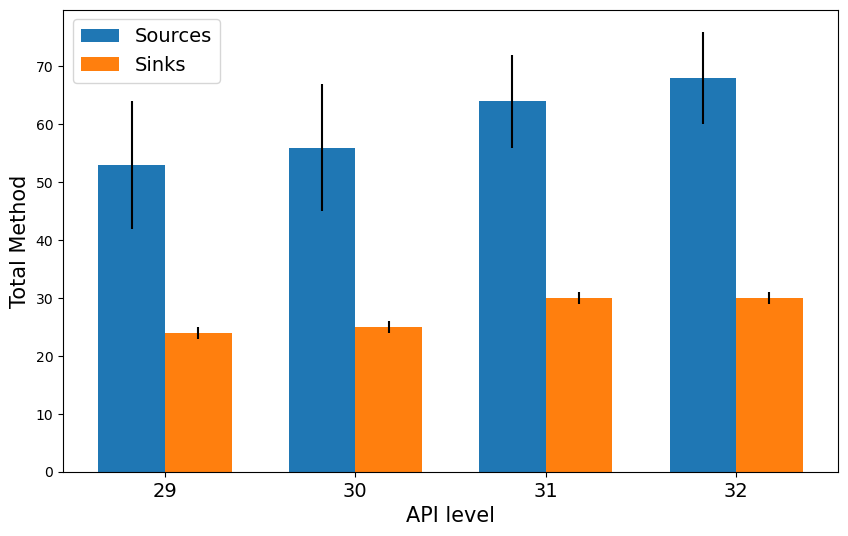

In [35]:
N = 4
sources = (53, 56, 64, 68)
sources_missed =   (11,11,8,8)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, sources, width, yerr=sources_missed) #color='royalblue'

sinks = (24,25,30,30)
sinks_missed =   (1,1,1,1)
rects2 = ax.bar(ind+width, sinks, width, yerr=sinks_missed) # , color='seagreen'

# add some formatting
ax.set_ylabel('Total Method', fontsize=15)
ax.set_xlabel('API level', fontsize=15)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels( (29,30,31,32),fontsize=14 )
ax.legend( (rects1[0], rects2[0]), ('Sources', 'Sinks'),fontsize=14 )

plt.show()

In [36]:
# use the fine-tuned model to get similar results as the paper
# The pre-trained model might not display the clusters as good as the fine-tuned model but still works
# sbert = SentenceTransformer('../embeddings/fine_tunned')
sbert = SentenceTransformer('all-mpnet-base-v2')

df_sosi = df_input.loc[df_input.classification.isin(['source','sink'])].copy()
class_map = {'source':0,'sink':1,'neither':0}
df_sosi['label'] = [class_map[x] for x in df_sosi['classification']]
corpus_sosi = df_sosi['docs'].values

#encode the corpus
sosi_embeddings = sbert.encode(corpus_sosi, batch_size=64, show_progress_bar=False, convert_to_tensor=True)

# dimensionality reduction with TSNE
tsne = TSNE(n_components=2, random_state=0)
vectors = tsne.fit_transform(sosi_embeddings)
df_sosi['x_vals'] = [v[0] for v in vectors]
df_sosi['y_vals'] = [v[1] for v in vectors]

In [37]:
map_vers = {'2018':'29','2020':'30','2021':'31','2022':'32'}
cluster_plot_full = df_sosi.loc[(df_sosi['version'].isin(['2021','2022'])) & (df_sosi['classification'].isin(['source','sink']))].copy()
cluster_plot_full['API level'] = [map_vers[x] for x in cluster_plot_full['version'].values]

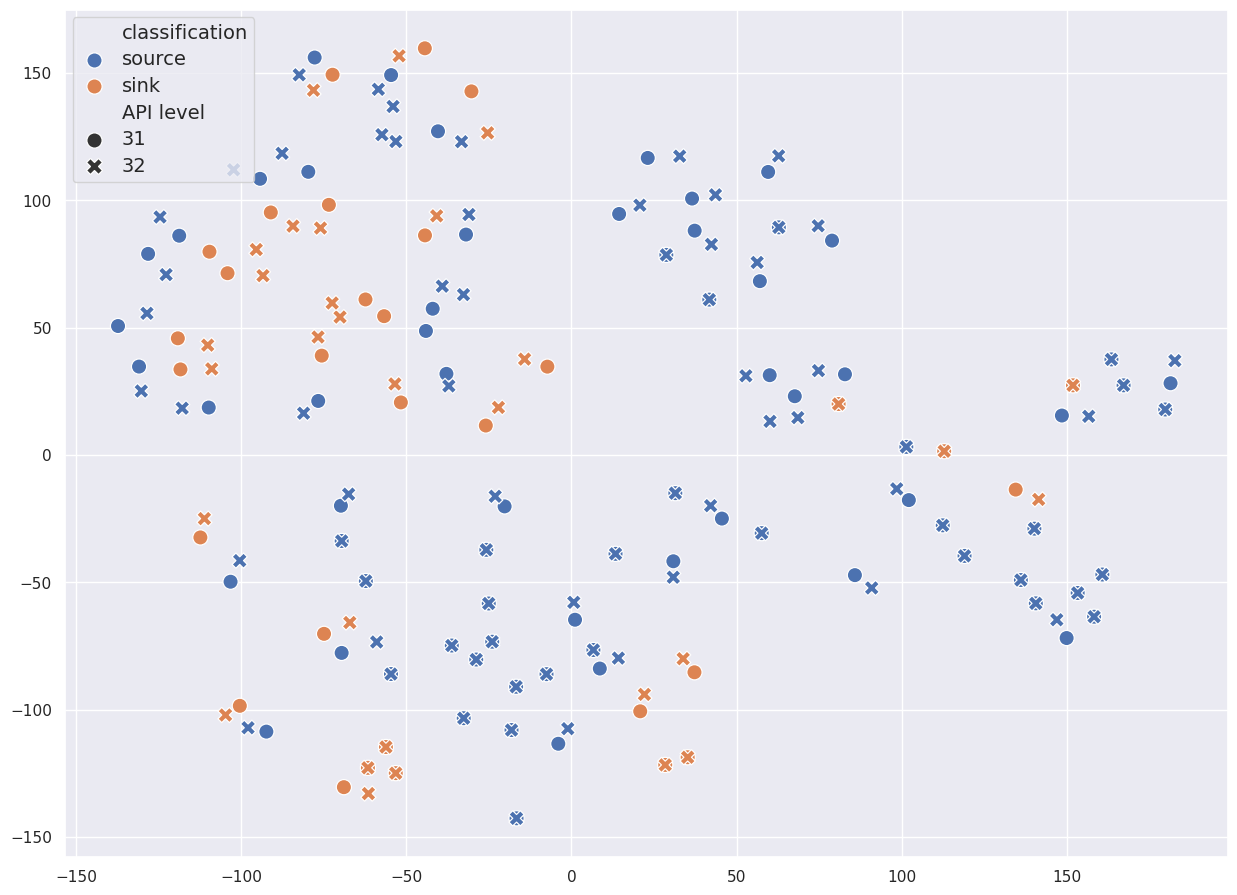

In [38]:
sns.set(rc={'figure.figsize':(15,11)})
markers =  {"31": "o", "32": "X"}

ax = sns.scatterplot(data=cluster_plot_full, x='x_vals', y='y_vals',
    hue='classification', style='API level',legend='brief',s=120,markers=markers)
ax.set(xlabel=None,ylabel=None)

# ax.tick_params(bottom=False)
sns.move_legend(ax, "upper left") #,bbox_to_anchor=(1, -0.1)
plt.setp(ax.get_legend().get_texts(), fontsize='14') 
plt.show()

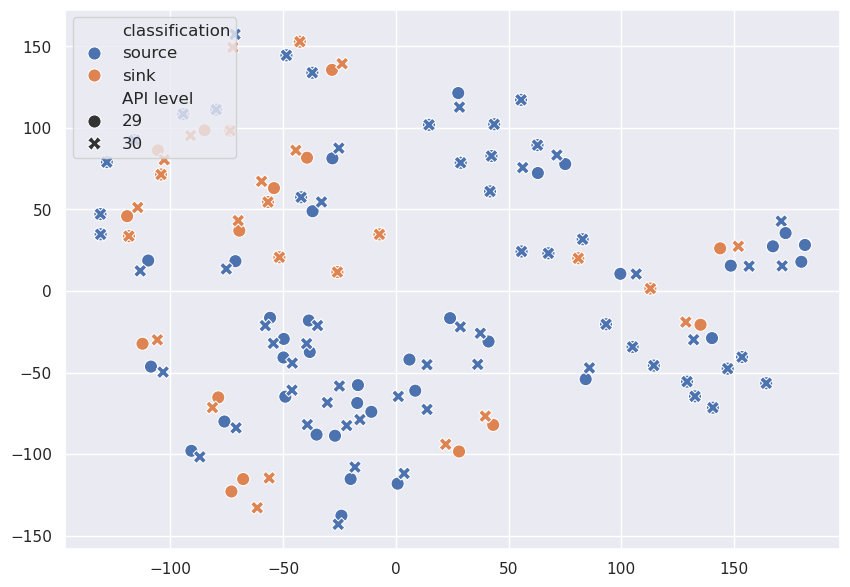

In [39]:
cluster_plot_full = df_sosi.loc[(df_sosi['version'].isin(['2018','2020'])) & (df_sosi['classification'].isin(['source','sink']))].copy()
cluster_plot_full['API level'] = [map_vers[x] for x in cluster_plot_full['version'].values]
sns.set(rc={'figure.figsize':(10,7)})
markers =  {"29": "o", "30": "X"}

ax = sns.scatterplot(data=cluster_plot_full, x='x_vals', y='y_vals',
    hue='classification', style='API level',legend='brief',s=90,markers=markers)
ax.set(xlabel=None,ylabel=None)

# ax.tick_params(bottom=False)
sns.move_legend(ax, "upper left") #,bbox_to_anchor=(1, -0.1)
plt.setp(ax.get_legend().get_texts(), fontsize='12') 
plt.show()